# HMM Example Notebook

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports and Plotting Functions 

In [2]:
import jax.random as jr
import jax.numpy as np
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

from ssm.hmm import GaussianHMM
from ssm.plots import gradient_cmap
from ssm.utils import find_permutation
import warnings

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()
    
def compare_transition_matrix(true_matrix, test_matrix):
    fig, axs = plt.subplots(1, 2)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes([axs[1].get_position().x1 + 0.07,
                        axs[1].get_position().y0,
                        0.02,
                        axs[1].get_position().y1-axs[1].get_position().y0])
    plt.colorbar(out, cax=cax)
    plt.show()

def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(states[None,:],
            aspect="auto",
            cmap=cmap,
            vmin=0,
            vmax=len(colors)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    for d in range(obs_dim):
        plt.plot(obs[:,d] + lim * d, '-k')

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()
    
def plot_posterior_states(Ez, states, perm):
    plt.figure(figsize=(20, 2))
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State")
    plt.plot(Ez.T[perm].argmax(axis=0), '--', label="Predicted State")
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title("Predicted vs. Ground Truth Latent State")
    plt.show()

In [3]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


# 1: Gaussian HMM

#### First, let's create a ground truth HMM model

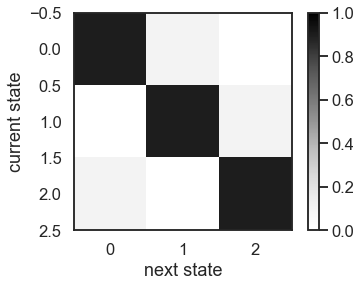

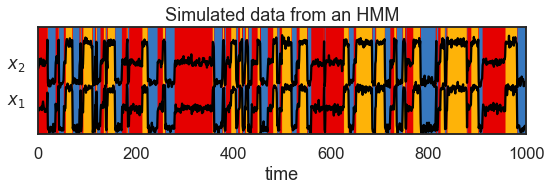

In [4]:
# define some parameters
num_states = 3
num_emission_dims = 2

transition_matrix = 0.9 * np.eye(num_states) \
                    + 0.1 * np.roll(np.eye(num_states), 1, axis=1)

emission_means = np.arange(6, dtype=float).reshape((3, 2)) - 3
emission_covariance=0.25**2 * np.eye(num_emission_dims)

# create the model
true_hmm = GaussianHMM(
    num_states=num_states, 
    num_emission_dims=num_emission_dims,
    transition_matrix=transition_matrix,
    emission_means=emission_means,
    emission_covariances=emission_covariance)

# sample latent states, observations (data) from the model
num_timesteps = 1000
states, data = true_hmm.sample(jr.PRNGKey(0), num_timesteps)

# view the sampled data
plot_transition_matrix(transition_matrix)
plot_hmm_data(data, states)

## Fit Gaussian HMM using EM on a single trial

In [5]:
# we initialize a random HMM which we will fit to our data
seed = jr.PRNGKey(1)
num_states_est = 3

test_hmm = GaussianHMM(
    num_states=num_states, 
    num_emission_dims=num_emission_dims,
    seed=seed)

Initializing...
initializing with kmeans
Done.


[converged] LP: -364.049:   2%|▏         | 2/100 [00:01<01:37,  1.00it/s]


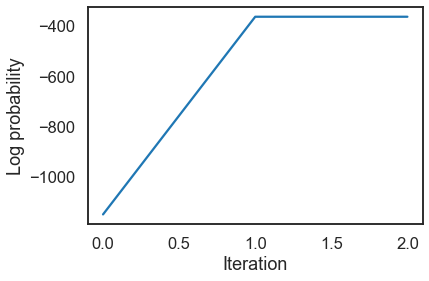

In [6]:
# fit the model using EM (for Gaussian HMM, we can perform exact EM)
log_probs, fitted_hmm, posterior = test_hmm.fit(data, method="em", tol=1e-5)

# plot the marginal log probability of the data as a function of number of fit steps
plt.plot(log_probs)
plt.ylabel("Log probability")
plt.xlabel("Iteration")
plt.show()

### Let's inspect the fitted model

In [9]:
# We can obtain the expected states from the posterior over latent states
Ez = posterior.expected_states[0]

# For discrete states, we can freely permute the state identity
# here, we find the best permutation to match up to our known states
# so that it's easier to compare our inferred states with the ground truth.
perm = find_permutation(states, np.argmax(Ez, axis=-1))

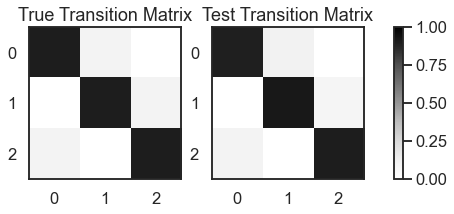

In [10]:
# Here, we compare the true and inferred transition matrix
compare_transition_matrix(true_hmm.transition_matrix, fitted_hmm.transition_matrix)

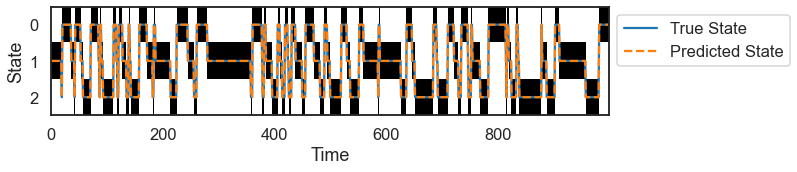

In [11]:
# Here, we plot the inferred state against the true state as a function of time. 
# The black rectangles represent the probability of the inferred state. We can 
# see that the model is very confident about the different state assignments.

plt.figure(figsize=(10, 2))
plt.imshow(Ez.T[perm, :], aspect="auto", interpolation="none", vmin=0, vmax=1, cmap="Greys")
plt.plot(states, '-', label="True State")
plt.plot(Ez.T[perm, :].argmax(axis=0), '--', label="Predicted State")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Time")
plt.ylabel("State")
plt.show()

## Fit Gaussian HMM on Multiple Trials

In [12]:
rng = jr.PRNGKey(0)
num_steps = 1000
num_trials = 5

all_states, all_data = true_hmm.sample(rng, num_steps=num_steps, num_samples=num_trials)

In [13]:
# here, we fit across the entire dataset using EM
# this is implemented by vmapping over the batch dim of our dataset
lps, fitted_hmm, posteriors = test_hmm.fit(all_data, method="em")

Initializing...
initializing with kmeans
Done.


[converged] LP: -2025.556:   2%|▏         | 2/100 [00:02<02:05,  1.28s/it]


In [14]:
# notice that our posteriors object has a batch dim for it's properties
# (one for each of the trials in our dataset)
print(posteriors.expected_states.shape)

(5, 1000, 3)


### Let's inspect our fitted model

With the additional trial examples, we notice that our model has recovered more of the true transition matrix!

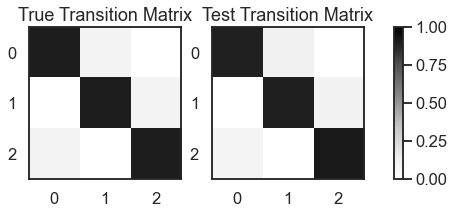

In [15]:
# Here, we compare the true and inferred transition matrix
Ez = posteriors.expected_states
perm = find_permutation(all_states[0], np.argmax(Ez[0], axis=-1))
compare_transition_matrix(true_hmm.transition_matrix, fitted_hmm.transition_matrix[np.ix_(perm, perm)])